In [1]:
from omegaconf import DictConfig
import importlib
import copy
from tqdm import tqdm

# import model_files
from qxr_utils.dicom.utils import get_array_from_dicom
from qxr_utils.image.transforms import scale, resize
from torch.utils.data import DataLoader
import torch.utils.data as data
import torch.nn.functional as fn


import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os

import torch
from torch.utils.data import Subset
import numpy as np


/home/users/shreshtha.singh/miniconda3/envs/qureai/lib/python3.9/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_type" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/users/shreshtha.singh/miniconda3/envs/qureai/lib/python3.9/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_output" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/users/shreshtha.singh/miniconda3/envs/qureai/lib/python3.9/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/users/shreshtha.singh/miniconda3/envs/qureai/lib/python3.9/site-pack

In [2]:
test_df = pd.read_csv(
    "/fast_data_e2e_1/cxr/qxr_ln_data/LN_test/combined_test_csv_updated_internal_test_13-08-24.csv")


In [3]:
class ScanD(data.Dataset):
    def __init__(self, imdict, imsize=960):
        self.imdict = imdict
        self.imsize = imsize
        self.indices = list(self.imdict.keys())

    def __getitem__(self, index):
        imid = self.indices[index]
        idx, im = self._get_im(imid)
        return {"id": idx, "input": im}

    def __len__(self):
        return len(self.indices)

    def _get_im(self, idx):
        try:
            impath = self.imdict[idx]
            ext = os.path.splitext(impath)[-1]
            if ext == ".dcm":
                try:
                    im = get_array_from_dicom(impath)
                except Exception as e:
                    #                     print(e)
                    im = None
            else:
                im = cv2.imread(impath, 0)
            if im is not None:
                im = resize(self.imsize, self.imsize)(im)
                im = scale(im)
                im = torch.Tensor(im).reshape(1, self.imsize, self.imsize)
                return idx, im
            else:
                return "none", torch.zeros(1, self.imsize, self.imsize)
        except Exception as e:
            print(e)
            print(idx)
            
            
def dict_to_df(preds):
    df = pd.DataFrame.from_dict(preds)
    df = df.transpose().reset_index()
    df = df.rename(columns={"index": "filename"})
    return df


In [10]:
test_df.columns

Index(['filename', 'src', 'nodule', 'nippleshadow', 'calcification',
       'granuloma', 'mass', 'ribfracture', 'consolidation', 'fibrosis',
       'ct recommended', 'solitary', 'artifact', 'subtlety', 'nipple_marker',
       'fibronodule', 'fibrolesion', 'miliarypattern', 'infectious_nodule',
       'tubr_nodule', 'LN', 'LNMS', 'bbox', 'png_path'],
      dtype='object')

In [4]:
png_dict = {}
for id , row in test_df[:100].iterrows():
    filename = row['filename']
    png_path = row['png_path']
    png_dict[filename] = png_path

In [5]:
dset = ScanD(png_dict, 960)

In [13]:
len(dset)

100

In [14]:
dset[0]['input'].shape

torch.Size([1, 960, 960])

In [6]:
dloader = DataLoader(dset, batch_size=16, num_workers=8)

In [16]:
len(dloader)

7

In [7]:
model = torch.jit.load('/fast_data_e2e11/abhishek/qureai/packages/python/qxr/traces_ts/v4_mass_upgrade_cuda.ts', map_location='cuda')

In [12]:
def run_model(model, dloader, names, seg=False, save_dir=None):
    
    if seg:
        assert save_dir, "save_dir not provided"
    
    preds = {}
    for batch in tqdm(dloader):
        with torch.no_grad():
            ids = batch['id']
            inputs = batch['input']
        
            out = model(inputs.to("cuda:0"))

            cls_out = out[0]
            seg_out = out[1]
            
            for tag in names:
                tdata = None
                sdata = None
                
                    
                if seg and (tag in seg_out):
                    # sdata = fn.softmax(seg_out[tag].cpu(), dim=1)
                    os.makedirs(os.path.join(save_dir, tag), exist_ok=True)

                tdata = cls_out[tag]
                sdata = seg_out[tag]
                ids = ['1.2.392.200036.9125.4.0.2955215972.839066288.762996930', 'f26315bb441a4aeaa6bb5bd6b45c6ad9', '02e743e928ca46909c38e185c854061f', '1c710196ab6e4254b7e31209ce156a01', '1.2.392.200036.9125.4.0.1378179521.4093715120.762996930', 'cb412dd20bfd4eaeb26a573603e98a37', 'f94964de96014302bc09ccfc2a67890f', '251aafb6345448568edbab6eabb05d05', '878d82d9b00e4b82824d85e94b5b52d8', '98a9fea040eb4ca1afcfdf0f30512cb4', 'f5b142784458451d9482e7f6e67c4e88', '29102b9ee63a469496bf3154f756c7d7', '1.2.392.200036.9125.4.0.1378198260.50668208.762996930', "none", '1.2.392.200036.9125.4.0.2217063622.2399230572.1521487960', '1.2.392.200036.9125.4.0.3877998013.3875676848.762996930']
                for i, idx in enumerate(ids):
                    if not idx in preds:
                        preds[idx] = {}
                        
                    if not (tdata is None):
                        preds[idx].update({tag: tdata[i].item()})
                        
                    if not (sdata is None):
                        s_out = sdata[i].detach().cpu().numpy()
                        binary_mask = (s_out > 0.3).astype(np.uint8) * 255
                        seg_max = s_out.max().item()
                        
                        preds[idx].update({f"{tag}_seg": seg_max})
                        # cv2.imwrite(f"{save_dir}/{tag}/{idx}.png", binary_mask)   
                        
                        
    
    return dict_to_df(preds)


In [13]:
pred_df = run_model(model,dloader, ['mass'], seg=True, save_dir="/fast_data_e2e_1/cxr/qxr_ln_data/testing_data_masks/mass")


 86%|████████▌ | 6/7 [00:25<00:04,  4.31s/it]


IndexError: index 4 is out of bounds for dimension 0 with size 4

In [80]:
pred_df

,filename,mass,mass_seg
0,1.2.392.200036.9125.4.0.2955215972.839066288.7...,0.022832,0.020939
1,f26315bb441a4aeaa6bb5bd6b45c6ad9,0.047018,0.090506
2,02e743e928ca46909c38e185c854061f,0.001445,0.001478
3,1c710196ab6e4254b7e31209ce156a01,0.004491,0.002310
4,1.2.392.200036.9125.4.0.1378179521.4093715120....,0.056682,0.048507
...,...,...,...
95,29069285cea0451688182dbb9411b6e9,0.003780,0.002707
96,3885fdf64e3647ceac474bd3e2554065,0.166193,0.102173
97,a66652a3a8754c3c9fc4d35bd70d4c83,0.022816,0.003524
98,1.2.392.200036.9125.4.0.2451942927.1359094448....,0.001884,0.002142


testset - 7 lakhs - internal ....
mass 
- cls thresh - (mass) - yoden index (thresh) - 0.72 (internal)
- seg thresh - mass_seg - yoden index (thresh) -  0.3 (internal)
- pixel threshold - set manually 

ribfracture - 
- cls thresh - (mass) - yoden index (thresh) - 0.6 
- seg thresh - mass_seg - yoden index (thresh) -  0.3



44


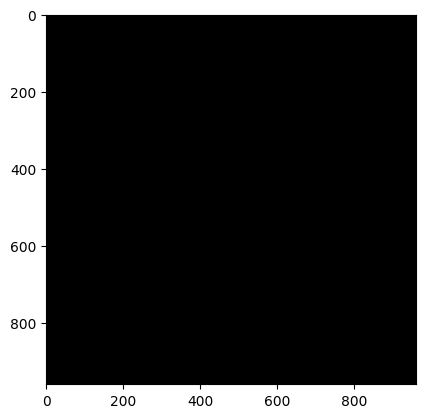

In [7]:
# Load the image in grayscale mode
img = cv2.imread("/fast_data_e2e_1/cxr/qxr_ln_data/testing_data_masks/mass/mass/fd217a225b4045818481c16462989f14.png", cv2.IMREAD_GRAYSCALE)
print(np.max(img))
# Normalize the image
img_normalized = img / 255.0

# Create a binary mask where the condition is true
mask = img_normalized > 0.3

# Apply the mask to the original image (optional: normalize for better visualization)
masked_img = img_normalized * mask

# Display the result
plt.imshow(masked_img, cmap='gray')
plt.show()